# Ejercicio 4 - Consigna
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

- a)	Entrenar un modelo de deep learning que no utilice embeddings.
- b)	Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
- c)	Compare el score de cada modelo y comente lo necesario.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (b)

## Cargamos el dataset

In [45]:
df = pd.read_csv("dataset_black_sales.csv")
df.fillna(0,inplace=True)  # reemplazamos los N/A de Product_Category_2 y Product_Category_3 por 0
df['y'] = df['Purchase'] >= 9000


## Analisis exploratorio

Gran parte del análisis exploratorio se realizó en el notebook del punto (a). En esta sección se harán análisis puntuales relacionados con el embedding.

In [46]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,y
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,False
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,True
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,False
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,False
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969,False


In [47]:
# df.groupby('Product_ID').describe()['Purchase']
# Para cada producto, varia la compra final que se hizo 

In [48]:
# Veamos la cantidad de valores únicos de algunos otros features
for i in ['User_ID', 'Product_ID']:
    print(i + ' unique values: ' + str(len(df[i].unique())))
# Veamos los valores unicos de algunos de los features
for i in ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']:
    print(i + ' values: ' + str(df[i].unique()) + ' - Total: ' + str(len(df[i].unique())))


User_ID unique values: 5891
Product_ID unique values: 3631
Gender values: ['F' 'M'] - Total: 2
Age values: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] - Total: 7
Occupation values: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] - Total: 21
City_Category values: ['A' 'C' 'B'] - Total: 3
Stay_In_Current_City_Years values: ['2' '4+' '3' '1' '0'] - Total: 5
Marital_Status values: [0 1] - Total: 2
Product_Category_1 values: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19] - Total: 20
Product_Category_2 values: [ 0.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.] - Total: 18
Product_Category_3 values: [ 0. 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.] - Total: 16


## Reducción de dimensionalidad y Codificación
Según las conclusiones obtenidas anteriormente en la exploración del dataset, procedemos a quitar algunas variables categóricas que tienen menor correlación con la variable de salida, ya que incluirlas durante el entrenamiento incurriría en un aumento significativo del dataset al hacer One-Hot Encoding o similar.
Sin embargo, nos quedamos con las features User_ID y Product_ID para aplicar embeddings.

In [49]:
dfa = df.copy()
dfa = dfa.drop(['Product_Category_2', 'Product_Category_3', 'Marital_Status', 'Stay_In_Current_City_Years', 'Purchase'], axis=1)
dfa.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Product_Category_1,y
0,1000001,P00069042,F,0-17,10,A,3,False
1,1000001,P00248942,F,0-17,10,A,1,True
2,1000001,P00087842,F,0-17,10,A,12,False
3,1000001,P00085442,F,0-17,10,A,12,False
4,1000002,P00285442,M,55+,16,C,8,False


In [50]:
# Gender lo codificamos binario
dfa['Gender'] = dfa['Gender'].apply(lambda x: 1 if x == 'M' else 0)

# Age con One-hot encoding
age_dummies = pd.get_dummies(dfa['Age'], prefix="age")
dfa = pd.concat([dfa,age_dummies], axis = 1)
dfa = dfa.drop(['Age'], axis=1)

# Occupation ya fue codificado, asumimos una asignación random e.g. Integer encoding (ya que no tenemos datos de cómo se asignaron números a las categorías).
# Probamos con OHE
occu_dummies = pd.get_dummies(dfa['Occupation'], prefix="occu")
dfa = pd.concat([dfa,occu_dummies], axis = 1)
dfa = dfa.drop(['Occupation'], axis=1)

# City_Category con One-hot encoding
dfa = pd.concat([dfa, pd.get_dummies(dfa['City_Category'], prefix="city")], axis = 1)
dfa = dfa.drop(['City_Category'], axis=1)

# Product_Category_1 idem Occupation

# Transformamos la salida a binario
dfa['y'] = dfa['y'].apply(lambda x: 1 if x==True else 0)

# Para el Product_ID, convertimos los string a numeros para optimizar el proceso con los embeddings
dfa['Product_ID'] = dfa['Product_ID'].apply(lambda x: int(x[1:]))

print(dfa.columns)

Index(['User_ID', 'Product_ID', 'Gender', 'Product_Category_1', 'y',
       'age_0-17', 'age_18-25', 'age_26-35', 'age_36-45', 'age_46-50',
       'age_51-55', 'age_55+', 'occu_0', 'occu_1', 'occu_2', 'occu_3',
       'occu_4', 'occu_5', 'occu_6', 'occu_7', 'occu_8', 'occu_9', 'occu_10',
       'occu_11', 'occu_12', 'occu_13', 'occu_14', 'occu_15', 'occu_16',
       'occu_17', 'occu_18', 'occu_19', 'occu_20', 'city_A', 'city_B',
       'city_C'],
      dtype='object')


## Preparacion Embeddings

In [51]:
user_nuniques = dfa['User_ID'].nunique()
user_min_val = dfa['User_ID'].min()
user_max_val = dfa['User_ID'].max()
print(f'User_ID: nUniques = {user_nuniques}')
print(f'Min val: {user_min_val} - Max val: {user_max_val} - Delta: {user_max_val-user_min_val}')
print('Continuous? ' + ('Yes' if (user_max_val-user_min_val) == user_nuniques else 'No'))
print()

product_nuniques = dfa['Product_ID'].nunique()
product_min_val = dfa['Product_ID'].min()
product_max_val = dfa['Product_ID'].max()
print(f'Product_ID: nUniques = {product_nuniques}')
print(f'Min val: {product_min_val} - Max val: {product_max_val} - Delta: {product_max_val-product_min_val}')
print('Continuous? ' + ('Yes' if (product_max_val-product_min_val) == product_nuniques else 'No'))


User_ID: nUniques = 5891
Min val: 1000001 - Max val: 1006040 - Delta: 6039
Continuous? No

Product_ID: nUniques = 3631
Min val: 142 - Max val: 375436 - Delta: 375294
Continuous? No


In [52]:
# Preparo dictionary para ir de User_ID y Product_ID a indice consecutivos de embeddings
userID_to_idx = {value:i for i,value in enumerate(dfa['User_ID'].unique())}
productID_to_idx = {value:i for i,value in enumerate(dfa['Product_ID'].unique())}

## Armado del dataset

In [53]:
dfa.head()

,User_ID,Product_ID,Gender,Product_Category_1,y,age_0-17,age_18-25,age_26-35,age_36-45,age_46-50,...,occu_14,occu_15,occu_16,occu_17,occu_18,occu_19,occu_20,city_A,city_B,city_C
0,1000001,69042,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1000001,248942,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1000001,87842,0,12,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1000001,85442,0,12,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1000002,285442,1,8,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [54]:
x = dfa.drop(['y', 'User_ID', 'Product_ID'], axis=1) 
print(x.columns)
y = dfa['y']

# Normalizamos para que el algoritmo de gradient descent converga más rápido.
x = x.to_numpy()
y = y.to_numpy()
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

# Creo vector de input para embeddings
dfa_userID_emb = np.array([userID_to_idx[value] for value in dfa['User_ID']])
dfa_productID_emb = np.array([productID_to_idx[value] for value in dfa['Product_ID']])


Index(['Gender', 'Product_Category_1', 'age_0-17', 'age_18-25', 'age_26-35',
       'age_36-45', 'age_46-50', 'age_51-55', 'age_55+', 'occu_0', 'occu_1',
       'occu_2', 'occu_3', 'occu_4', 'occu_5', 'occu_6', 'occu_7', 'occu_8',
       'occu_9', 'occu_10', 'occu_11', 'occu_12', 'occu_13', 'occu_14',
       'occu_15', 'occu_16', 'occu_17', 'occu_18', 'occu_19', 'occu_20',
       'city_A', 'city_B', 'city_C'],
      dtype='object')


In [55]:
# Divido en entrenamiento y validación

from sklearn.model_selection import train_test_split
# Divido el dataset
train_percentage = 0.85 
idx = np.random.permutation(x_norm.shape[0])
train_idx = idx[0:int(train_percentage*len(idx))]
valid_idx = idx[int(train_percentage*len(idx)):]

n_train = train_idx.shape[0]
n_valid = valid_idx.shape[0]

# Divido features originales
x_train = x_norm[train_idx]
y_train = y[train_idx]
x_valid = x_norm[valid_idx]
y_valid = y[valid_idx]

# Divido embeddings
x_userID_train = dfa_userID_emb[train_idx]
x_userID_valid = dfa_userID_emb[valid_idx]

x_productID_train = dfa_productID_emb[train_idx]
x_productID_valid = dfa_productID_emb[valid_idx]

## Pytorch

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [69]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDatasetWithEmbddings(Dataset):
  def __init__(self, x, x_userID, x_productID, y):
    self.x = x
    self.x_userID = x_userID
    self.x_productID = x_productID
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.x_userID[idx], self.x_productID[idx], self.y[idx]

In [70]:
train_ds_embeddings = MyDatasetWithEmbddings(x_train, x_userID_train, x_productID_train, y_train)
valid_ds_embeddings = MyDatasetWithEmbddings(x_valid, x_userID_valid, x_productID_valid, y_valid)

In [71]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds_embeddings, batch_size = 128, shuffle= True)
valid_dataloader = DataLoader(valid_ds_embeddings, batch_size = 128)

### Arquitectura NNet Pytorch
La red neuronal en Pytorch se define extendiendo torch.nn.Module

In [72]:
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    # Defino la arquitectura de la red
    super().__init__()

    global user_nuniques
    global product_nuniques
    dim_user = 8  # dimensiones del embedding de user
    dim_product = 8  # dimensiones del embedding de product
    
    # Embeddings
    self.emb_user = torch.nn.Embedding(num_embeddings=user_nuniques, embedding_dim=dim_user)
    self.emb_product = torch.nn.Embedding(num_embeddings=product_nuniques, embedding_dim=dim_product)
    
    # NN architecture
    self.linear_1 = torch.nn.Linear(in_features=33 + dim_user + dim_product, out_features=64, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 64, out_features=64, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features = 64, out_features=128, bias=True)
    self.relu_3 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 128, out_features= 1, bias=True)

  def forward(self, x, x_emb_user, x_emb_product):
    values_emb_user = self.emb_user(x_emb_user)
    values_emb_product = self.emb_product(x_emb_product)
    x = torch.cat([x, values_emb_user, values_emb_product], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.relu_3(x)
    x = self.output(x)
    return x

In [73]:
# Instanciamos la red
device = "cpu"
nnetWithEmbeddings = NNetWithEmbeddings()
nnetWithEmbeddings = nnetWithEmbeddings.to(device)

### Loss y optimizador
- Como loss function utilizo BCE por ser un problema de clasificación binaria.

**Nota**: la función sigmoid de salida no se definió en la arquitectura de la red neuronal porque utilizo BCEWithLogitsLoss que combina sigmoid+BCE. Hago esto para tener mejor estabilidad numérica: [link](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Podría utilizar BCELoss y agregar la capa sigmoid en la clase NNet

- Como optimizador utilizo Adam

In [76]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(nnetWithEmbeddings.parameters(), lr=0.001, weight_decay=0.05)

## Entrenamiento y validación red neuronal

Entreno con algoritmo Mini-Batch

In [77]:
# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnetWithEmbeddings.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, x_user_batch, x_product_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    x_user_batch = x_user_batch.to(device).int()
    x_product_batch = x_product_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnetWithEmbeddings(x_batch, x_user_batch, x_product_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnetWithEmbeddings.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, x_user_batch, x_product_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    x_user_batch = x_user_batch.to(device).int()
    x_product_batch = x_product_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnetWithEmbeddings(x_batch, x_user_batch, x_product_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.266 / 0.267 | Train/Valid accuracy: 0.881 / 0.881
 Epoch 1 | Train/Valid loss: 0.260 / 0.263 | Train/Valid accuracy: 0.884 / 0.882
 Epoch 2 | Train/Valid loss: 0.257 / 0.260 | Train/Valid accuracy: 0.885 / 0.882
 Epoch 3 | Train/Valid loss: 0.255 / 0.259 | Train/Valid accuracy: 0.886 / 0.884
 Epoch 4 | Train/Valid loss: 0.254 / 0.259 | Train/Valid accuracy: 0.886 / 0.883
 Epoch 5 | Train/Valid loss: 0.253 / 0.259 | Train/Valid accuracy: 0.886 / 0.883
 Epoch 6 | Train/Valid loss: 0.253 / 0.259 | Train/Valid accuracy: 0.887 / 0.883
 Epoch 7 | Train/Valid loss: 0.252 / 0.259 | Train/Valid accuracy: 0.887 / 0.883
 Epoch 8 | Train/Valid loss: 0.252 / 0.260 | Train/Valid accuracy: 0.887 / 0.883
 Epoch 9 | Train/Valid loss: 0.252 / 0.259 | Train/Valid accuracy: 0.887 / 0.884
 Epoch 10 | Train/Valid loss: 0.251 / 0.259 | Train/Valid accuracy: 0.887 / 0.883
 Epoch 11 | Train/Valid loss: 0.251 / 0.260 | Train/Valid accuracy: 0.888 / 0.883
 Epoch 12 | Train/Valid lo

## Resultados

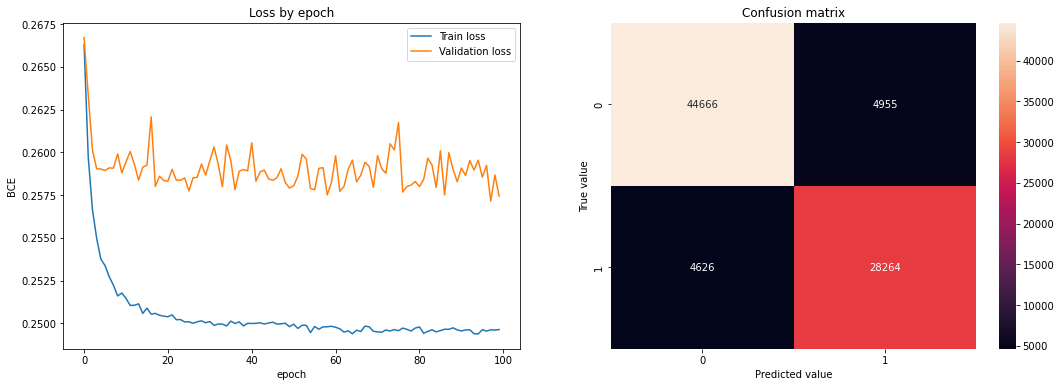

In [78]:
plt.figure(figsize=(18,6))
ax1= plt.subplot(1,2,1)
ax1.plot(train_loss_by_epoch, label="Train loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")
ax2= plt.subplot(1,2,2)
cm = metrics.confusion_matrix(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])
sns.heatmap(cm, annot=True, fmt='g', ax=ax2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()